In [1]:
import numpy as np
import matplotlib.pyplot as plt

import interpolate_matrix as matint
import integrand_interpolation as integ

In [2]:
class epsilon:
    def __init__(self, max_linspace, N_LS, N_GL):
        self.linspace_max = max_linspace
        self.N_LS = N_LS
        self.N_GL = N_GL

        x_GL, w_GL = np.polynomial.laguerre.laggauss(N_GL)

        self.eps = np.zeros(N_LS + N_GL)
        self.w = np.zeros_like(self.eps)
        
        self.eps[:N_LS] = np.linspace(0, max_linspace, N_LS)
        self.eps[N_LS:] = x_GL + max_linspace

        self.w[:N_LS] = self.eps[1]
        self.w[0] *= 0.5
        self.w[N_LS-1] *= 0.5
        self.w[N_LS:] = w_GL * np.exp(self.eps[N_LS:]-max_linspace)

class density:
    def __init__(self, max_linspace, N_LS, N_GL, func_e, func_m):
        self.fun_e = func_e
        self.fun_m = func_m

        self.e = epsilon(max_linspace, N_LS, N_GL)
        self.rho = matint.dens_array(self.e.eps, self.fun_e, self.fun_m)

    def fg_exact(self, p_all):
        f = np.zeros(5)
        g = np.zeros(5)
        for i in range(1,5):
            f[i] = self.fun_e(p_all[i-1])
            g[i] = self.fun_m(p_all[i-1])
        return f, g

    def fg_interp_extrap(self, p_all):
        f = np.zeros(5)
        g = np.zeros(5)
        for i in range(1, 5):
            temp = matrix_interp_extrap(p_all[i-1], self.e, self.rho)
            fe_temp = 0.5 * temp[0] * (1 + temp[3])
            fm_temp = 0.5 * temp[0] * (1 - temp[3])

            f[i] = fe_temp
            g[i] = fm_temp
        return f, g

In [3]:
def matrix_interp_extrap(x, e_epsilon, P_arrays):
    rho_ee = np.zeros(len(e_epsilon.eps))
    rho_mm = np.zeros_like(rho_ee)

    rho_ee[:] = 0.5 * P_arrays[:,0] * (1 + P_arrays[:,3])
    rho_mm[:] = 0.5 * P_arrays[:,0] * (1 - P_arrays[:,3])

    if x > np.max(e_epsilon.eps[:-1]):
        fe_temp = np.exp(matint.linear_fit(x, e_epsilon.eps[-2:], np.log(rho_ee[-2:])))
        fm_temp = np.exp(matint.linear_fit(x, e_epsilon.eps[-2:], np.log(rho_mm[-2:])))
    else:
        if x < e_epsilon.linspace_max:
            func = matint.interpolate_log_fifth
        else:
            func = matint.interpolate_log_linear
    
        fe_temp = func(x, e_epsilon.eps, rho_ee)
        fm_temp = func(x, e_epsilon.eps, rho_mm)

    return np.array([fe_temp + fm_temp, 0, 0, (fe_temp - fm_temp)/(fe_temp + fm_temp + 1e-100)])

In [35]:
def inner_integral(p1, p2, dens):
    FJ = np.zeros((2,2,len(dens.e.eps)))
    for i in range(len(dens.e.eps)):
        p4 = p1 + p2 - dens.e.eps[i]

        T1 = 0
        T2 = 0

        T1_i = 0
        T2_i = 0
        
        if p4 > 0:
            p_array = np.array([p1, p2, dens.e.eps[i], p4])
            f, g = dens.fg_exact(p_array)
            T1, T2 = integ.Fvv(f, g)

            f2, g2 = dens.fg_interp_extrap(p_array)
            T1_i, T2_i = integ.Fvv(f2, g2)

        FJ[0, 0, i] = T1 - T2
        FJ[0, 1, i] = T1 + T2

        FJ[1, 0, i] = T1_i - T2_i
        FJ[1, 1, i] = T1_i + T2_i

        FJ[:, :, i] *= integ.J(p1, p2, dens.e.eps[i])

    results = np.zeros(4)
    for i in range(4):
        results[i] = np.sum(FJ[i//2, i%2, :] * dens.e.w)

    return results

def truth_inner_integral(p1, p2, dens, N_fine = 20):
    dx_temp = dens.e.eps[1] / N_fine
    N_steps = int((p1+p2)/dx_temp)
    eps_trap = np.linspace(0, p1+p2, N_steps)

    FJ = np.zeros((2, N_steps))

    for i in range(N_steps):
        p4 = p1 + p2 - eps_trap[i]
        p_array = np.array([p1, p2, eps_trap[i], p4])
        f, g = dens.fg_exact(p_array)
        T1, T2 = integ.Fvv(f,g)

        FJ[0, i] = T1 - T2
        FJ[1, i] = T1 + T2

        FJ[:,i] *= integ.J(p1, p2, eps_trap[i])

    return np.trapz(FJ[0,:], eps_trap), np.trapz(FJ[1,:], eps_trap)

def og_inner_integral(p1, p2, dens):
    lin_indices = np.where(dens.e.eps <= p1+p2)[0]
    N_steps = len(lin_indices)
    if p1+p2 != dens.e.eps[lin_indices[-1]]:
        N_steps += 1
    p3 = np.zeros(N_steps)
    p3[lin_indices] = dens.e.eps[lin_indices]
    if p3[-1] == 0:
        p3[-1] = p1+p2

    FJ = np.zeros((2, N_steps))
    for i in range(N_steps):
        p4 = p1 + p2 - p3[i]
        p_array = np.array([p1, p2, p3[i], p4])
        f, g = dens.fg_exact(p_array)
        T1, T2 = integ.Fvv(f,g)

        FJ[0, i] = T1 - T2
        FJ[1, i] = T1 + T2

        FJ[:,i] *= integ.J(p1, p2, p3[i])

    return np.trapz(FJ[0,:], p3), np.trapz(FJ[1,:], p3)


In [5]:
rho_og = density(10, 201, 5, integ.f_FD_e, integ.f_FD_m)

In [6]:
%%time
integrand_2 = np.zeros((4,len(rho_og.e.eps)))
for i in range(len(integrand_2[0])):
    integrand_2[:,i] = inner_integral(rho_og.e.eps[100], rho_og.e.eps[i], rho_og) 

CPU times: user 4.31 s, sys: 20.8 ms, total: 4.33 s
Wall time: 4.32 s


In [7]:
%%time
tr_2 = np.zeros((2, len(rho_og.e.eps)))
for i in range(len(tr_2[0])):
    tr_2[:,i] = truth_inner_integral(rho_og.e.eps[100], rho_og.e.eps[i], rho_og)

CPU times: user 8.1 s, sys: 6.64 ms, total: 8.11 s
Wall time: 8.11 s


In [36]:
%%time
og_2 = np.zeros((2, len(rho_og.e.eps)))
for i in range(len(og_2[0])):
    og_2[:,i] = og_inner_integral(rho_og.e.eps[100], rho_og.e.eps[i], rho_og)

CPU times: user 399 ms, sys: 3.32 ms, total: 402 ms
Wall time: 401 ms


/var/folders/9_/mvz7zy8s75d54b6716vd69695_lgwz/T/ipykernel_93138/1215386766.py:1: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(rho_og.e.eps, np.abs(1-integrand_2[3,:]/integrand_2[1,:]))


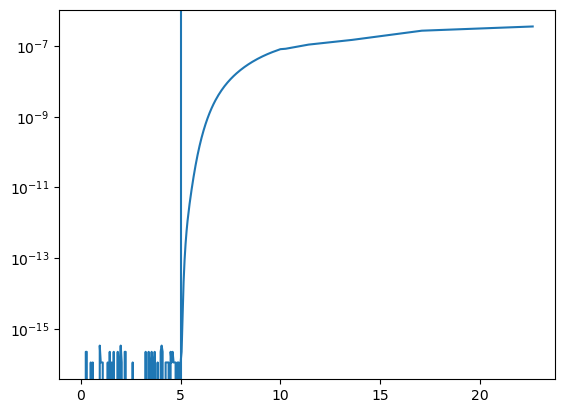

In [100]:
plt.semilogy(rho_og.e.eps, np.abs(1-integrand_2[3,:]/integrand_2[1,:]))
plt.axvline(rho_og.e.linspace_max-rho_og.e.eps[100])

/var/folders/9_/mvz7zy8s75d54b6716vd69695_lgwz/T/ipykernel_93138/2443313059.py:1: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(rho_og.e.eps, np.abs(integrand_2[2,:]/integrand_2[3,:]))


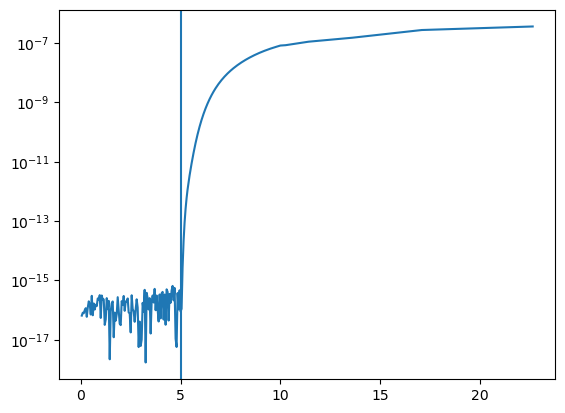

In [101]:
plt.semilogy(rho_og.e.eps, np.abs(integrand_2[2,:]/integrand_2[3,:]))
plt.axvline(rho_og.e.linspace_max-rho_og.e.eps[100])

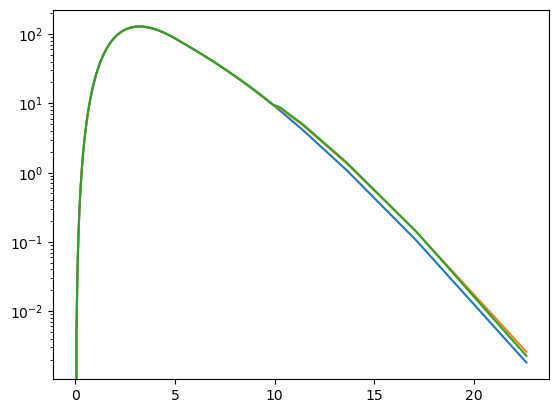

In [37]:
plt.semilogy(rho_og.e.eps, tr_2[1,:])
plt.semilogy(rho_og.e.eps, integrand_2[1,:])
plt.semilogy(rho_og.e.eps, og_2[1,:])

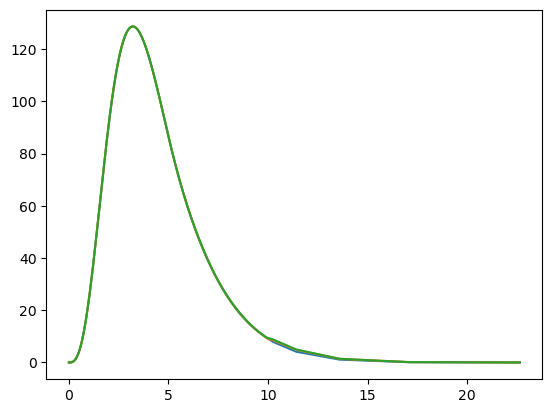

In [38]:
plt.plot(rho_og.e.eps, tr_2[1,:])
plt.plot(rho_og.e.eps, integrand_2[1,:])
plt.plot(rho_og.e.eps, og_2[1,:])

In [47]:
f = np.exp(-e.eps)

In [48]:
np.sum(f * e.w)

1.0008331944757876

In [10]:
ee = np.linspace(0,20,201)
ff = np.exp(-ee)

np.trapz(ff,ee), 1 - np.exp(-10), np.exp(-10)

(1.0008331924146339, 0.9999546000702375, 4.5399929762484854e-05)

In [12]:
rho = matint.dens_array(e_og.eps, int.f_FD_e, int.f_FD_m)

In [27]:
x = np.linspace(0,25,1000)
f = np.zeros_like(x)

for i in range(len(x)):
    g = matrix_interp_extrap(x[i], e_og, rho)
    f[i] = 0.5 * g[0] * (1 + g[3])

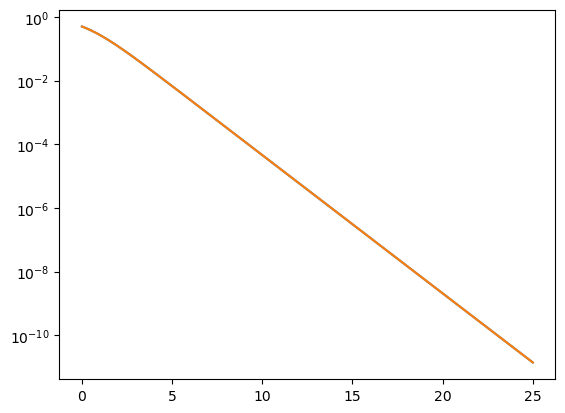

In [21]:
plt.semilogy(x, f)
plt.semilogy(x, int.f_FD_e(x))

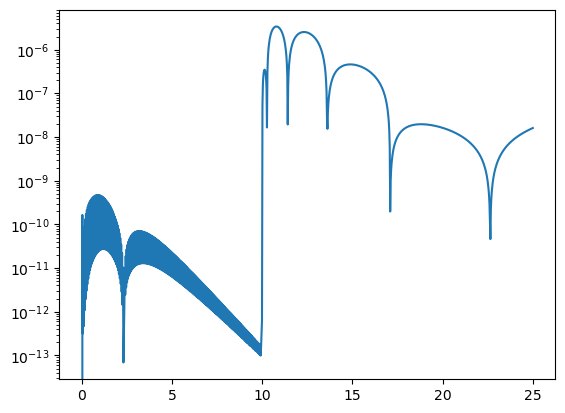

In [23]:
plt.semilogy(x, np.abs(1-f/int.f_FD_e(x)))


In [56]:
rho_og.e.eps

array([ 0.        ,  0.05      ,  0.1       ,  0.15      ,  0.2       ,
        0.25      ,  0.3       ,  0.35      ,  0.4       ,  0.45      ,
        0.5       ,  0.55      ,  0.6       ,  0.65      ,  0.7       ,
        0.75      ,  0.8       ,  0.85      ,  0.9       ,  0.95      ,
        1.        ,  1.05      ,  1.1       ,  1.15      ,  1.2       ,
        1.25      ,  1.3       ,  1.35      ,  1.4       ,  1.45      ,
        1.5       ,  1.55      ,  1.6       ,  1.65      ,  1.7       ,
        1.75      ,  1.8       ,  1.85      ,  1.9       ,  1.95      ,
        2.        ,  2.05      ,  2.1       ,  2.15      ,  2.2       ,
        2.25      ,  2.3       ,  2.35      ,  2.4       ,  2.45      ,
        2.5       ,  2.55      ,  2.6       ,  2.65      ,  2.7       ,
        2.75      ,  2.8       ,  2.85      ,  2.9       ,  2.95      ,
        3.        ,  3.05      ,  3.1       ,  3.15      ,  3.2       ,
        3.25      ,  3.3       ,  3.35      ,  3.4       ,  3.45